<a href="https://colab.research.google.com/github/mosvlad/NeuralArtist/blob/master/Copy_of_Untitled13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/Culture Shock (Drums).mp3  
  inflating: data/Culture Shock (E Drums).mp3  
  inflating: data/Culture Shock (FX).mp3  
  inflating: data/Culture Shock (Instrumental).mp3  
  inflating: data/Culture Shock (Synth).mp3  
  inflating: data/Culture Shock (Vocal).mp3  


In [0]:
%tensorflow_version 1.x

[MoviePy] Writing audio in data/Culture Shock (E Drums).wav


100%|██████████| 4638/4638 [00:02<00:00, 2123.98it/s]

[MoviePy] Done.


[MoviePy] Writing audio in data/Culture Shock (Drums).wav


100%|██████████| 4638/4638 [00:02<00:00, 2216.75it/s]

[MoviePy] Done.


[MoviePy] Writing audio in data/Culture Shock (Synth).wav


100%|██████████| 4638/4638 [00:02<00:00, 2167.04it/s]

[MoviePy] Done.


[MoviePy] Writing audio in data/Culture Shock (Vocal).wav


100%|██████████| 4638/4638 [00:02<00:00, 2111.92it/s]

[MoviePy] Done.


[MoviePy] Writing audio in data/Culture Shock (FX).wav


100%|██████████| 4638/4638 [00:02<00:00, 2142.15it/s]

[MoviePy] Done.


[MoviePy] Writing audio in data/Culture Shock (Instrumental).wav


100%|██████████| 4638/4638 [00:02<00:00, 2100.55it/s]

[MoviePy] Done.


[MoviePy] >>>> Building video data/Culture Shock.mp4
[MoviePy] Writing audio in Culture ShockTEMP_MPY_wvf_snd.mp4


100%|██████████| 4638/4638 [00:08<00:00, 518.58it/s]

[MoviePy] Done.
[MoviePy] Writing video data/Culture Shock.mp4



100%|██████████| 12619/12619 [35:03<00:00,  6.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: data/Culture Shock.mp4 



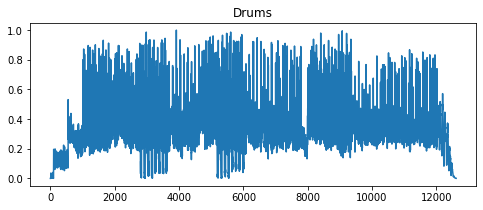

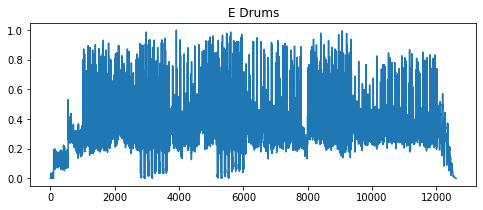

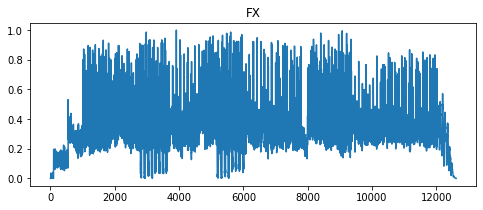

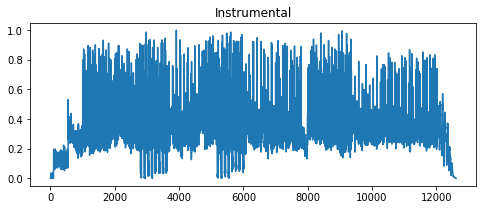

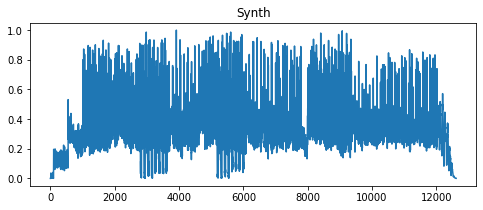

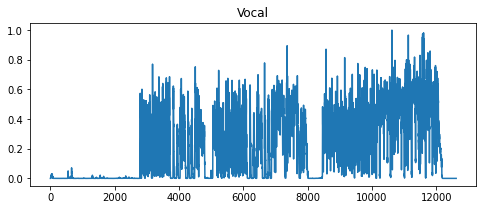

In [11]:
import os
import numpy as np
from scipy.interpolate import interp1d
from scipy.io import wavfile
import matplotlib.pyplot as plt
import PIL.Image
import moviepy.editor

import dnnlib
import dnnlib.tflib as tflib
import pretrained_networks

audio = {}
fps = 60

# https://www.google.com/search?q=death+grips+black+google+download
for mp3_filename in [f for f in os.listdir('data') if f.endswith('.mp3')]:
    mp3_filename = f'data/{mp3_filename}'
    wav_filename = mp3_filename[:-4] + '.wav'
    if not os.path.exists(wav_filename):
        audio_clip = moviepy.editor.AudioFileClip(mp3_filename)
        audio_clip.write_audiofile(wav_filename, fps=44100, nbytes=2, codec='pcm_s16le')
    track_name = os.path.basename(wav_filename)[15:-5]
    rate, signal = wavfile.read(wav_filename)
    signal = np.mean(signal, axis=1) # to mono
    signal = np.abs(signal)
    seed = signal.shape[0]
    duration = signal.shape[0] / rate
    frames = int(np.ceil(duration * fps))
    samples_per_frame = signal.shape[0] / frames
    audio[track_name] = np.zeros(frames, dtype=signal.dtype)
    for frame in range(frames):
        start = int(round(frame * samples_per_frame))
        stop = int(round((frame + 1) * samples_per_frame))
        audio[track_name][frame] = np.mean(signal[start:stop], axis=0)
    audio[track_name] /= max(audio[track_name])

for track in sorted(audio.keys()):
    plt.figure(figsize=(8, 3))
    plt.title(track)
    plt.plot(audio[track])
    plt.savefig(f'data/{track}.png')

network_pkl = 'gdrive:networks/stylegan2-ffhq-config-f.pkl'
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)

Gs_kwargs = dnnlib.EasyDict()
Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_kwargs.randomize_noise = False
Gs_syn_kwargs = dnnlib.EasyDict()
Gs_syn_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_syn_kwargs.randomize_noise = False
Gs_syn_kwargs.minibatch_size = 4
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
w_avg = Gs.get_var('dlatent_avg')

def get_ws(n, frames, seed):
    filename = f'data/ws_{n}_{frames}_{seed}.npy'
    if not os.path.exists(filename):
        src_ws = np.random.RandomState(seed).randn(n, 512)
        ws = np.empty((frames, 512))
        for i in range(512):
            # FIXME: retarded
            x = np.linspace(0, 3*frames, 3*len(src_ws), endpoint=False)
            y = np.tile(src_ws[:, i], 3)
            x_ = np.linspace(0, 3*frames, 3*frames, endpoint=False)
            y_ = interp1d(x, y, kind='quadratic', fill_value='extrapolate')(x_)
            ws[:, i] = y_[frames:2*frames]
        np.save(filename, ws)
    else:
        ws = np.load(filename)
    return ws

def mix_styles(wa, wb, ivs):
    w = np.copy(wa)
    for i, v in ivs:
        w[i] = wa[i] * (1 - v) + wb[i] * v
    return w

def normalize_vector(v):
    return v * np.std(w_avg) / np.std(v) + np.mean(w_avg) - np.mean(v)

def render_frame(t):
    global base_index
    frame = np.clip(np.int(np.round(t * fps)), 0, frames - 1)
    base_index += base_speed * audio['Instrumental'][frame]**2
    base_w = base_ws[int(round(base_index)) % len(base_ws)]
    base_w = np.tile(base_w, (18, 1))
    psi = 0.5 + audio['FX'][frame] / 2
    base_w = w_avg + (base_w - w_avg) * psi
    mix_w = np.tile(mix_ws[frame], (18, 1))
    mix_w = w_avg + (mix_w - w_avg) * 0.75
    ranges = [range(0, 4), range(4, 8), range(8, 18)]
    values = [audio[track][frame] for track in ['Drums', 'E Drums', 'Synth']]
    w = mix_styles(base_w, mix_w, zip(ranges, values))
    w += mouth_open * audio['Vocal'][frame] * 1.5
    image = Gs.components.synthesis.run(np.stack([w]), **Gs_syn_kwargs)[0]
    image = PIL.Image.fromarray(image).resize((size, size), PIL.Image.LANCZOS)
    return np.array(image)
    
size = 1080
seconds = int(np.ceil(duration))
resolution = 10
base_frames = resolution * frames
base_ws = get_ws(seconds, base_frames, seed)
base_speed = base_frames / sum(audio['Instrumental']**2)
base_index = 0
mix_ws = get_ws(seconds, frames, seed + 1)
# https://rolux.org/media/stylegan2/vectors/mouth_ratio.npy
mouth_open = normalize_vector(-np.load('mouth_ratio.npy'))

mp4_filename = 'data/Culture Shock.mp4'
video_clip = moviepy.editor.VideoClip(render_frame, duration=duration)
audio_clip_i = moviepy.editor.AudioFileClip('data/Culture Shock (Instrumental).wav')
audio_clip_v = moviepy.editor.AudioFileClip('data/Culture Shock (Vocal).wav')
audio_clip = moviepy.editor.CompositeAudioClip([audio_clip_i, audio_clip_v])
video_clip = video_clip.set_audio(audio_clip)
video_clip.write_videofile(mp4_filename, fps=fps, codec='libx264', audio_codec='aac', bitrate='8M')